# Calculations for baseline water stress and gap to sustainable water use

In [1]:
# Set up environment
import pandas as pd
import geopandas as gpd
import requests
import rasterio as rio
import rasterio.plot
import requests
import shapely.wkb
import numpy as np
from rasterstats import zonal_stats
from shapely.geometry import Polygon, Point, MultiPolygon
from matplotlib import pyplot as plt
import os

# Sample input data

We'll make up two sources of raw materials for this example. Almonds sourced from California, and wheat flour sourced from an industrial mill in Ukraine.

In [2]:
# Load sample data into table
sample_data = gpd.GeoDataFrame([
    {
        'location': 'California',
        'raw material': 'almonds',
        'tonnage': 15,
        'year':2017
    },
    {
        'location': 'Mill @ 36N, 49E',
        'raw material': 'wheat flour',
        'tonnage': 2100,
        'year':2017
    }
])
sample_data.head()

,location,raw material,tonnage,year
0,California,almonds,15,2017
1,"Flour mill @ 36N, 49E",wheat flour,2100,2017


# Get geometries

When we know the exact location of a farm source for a raw material, we can just take point value of baseline water stress for that location.

In these two examples we don't know the exact farm locations, so we'll estimate baseline water stress for the administrative region (for California almonds) or supply-shed (for the flour mill) of the raw material supplier.

,location,raw material,tonnage,year,geometry
0,California,almonds,15,2017,(POLYGON ((-117.2328491210937 32.7764053344726...
1,"Flour mill @ 36N, 49E",wheat flour,2100,2017,"POLYGON ((37 49, 36.9951847266722 48.901982859..."


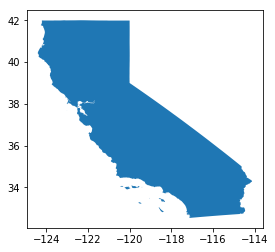

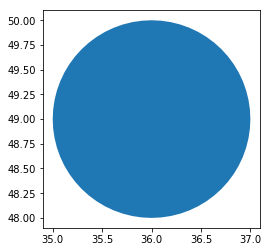

In [3]:
# Get geometry of California from table
queryUrl = 'https://api.resourcewatch.org/v1/query/Politcial-Boundaries-GADM-adminitrative-level-1-1490086842541'
queryParams = {'sql': "select the_geom from gadm28_adm1 where name_1='California'"}
resp = requests.get(queryUrl, queryParams)
cali_geom = shapely.wkb.loads(resp.json()['data'][0]['the_geom'], hex=True)

# For the mill location we'll use an approximate 100km radius supply-shed around the point location
point_geom = Point(36, 49).buffer(1)

# Update table
sample_data['geometry'] = [cali_geom, point_geom]
sample_data[sample_data.index==0].plot()
sample_data[sample_data.index==1].plot()
sample_data.head()

# Download source data

Baseline water stress data from Aqueduct is reported by river basin.

In [4]:
!curl -O https://s3.us-east-2.amazonaws.com/earthstatdata/HarvestedAreaYield175Crops_Indvidual_Geotiff/wheat_HarvAreaYield_Geotiff.zip
!curl -O https://s3.us-east-2.amazonaws.com/earthstatdata/HarvestedAreaYield175Crops_Indvidual_Geotiff/almond_HarvAreaYield_Geotiff.zip
!curl -O http://data.wri.org/Aqueduct/web/aqueduct_global_maps_21_shp.zip
!unzip -oq wheat_HarvAreaYield_Geotiff.zip
!unzip -oq almond_HarvAreaYield_Geotiff.zip
!unzip -oq aqueduct_global_maps_21_shp.zip

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  9.9M  100  9.9M    0     0  6043k      0  0:00:01  0:00:01 --:--:-- 6042k
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 4065k  100 4065k    0     0  6170k      0 --:--:-- --:--:-- --:--:-- 6177k
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 73.1M  100 73.1M    0     0  13.5M      0  0:00:05  0:00:05 --:--:-- 14.4M


In [5]:
bws = gpd.read_file("aqueduct_global_dl_20150409.shp")
#bws.head()

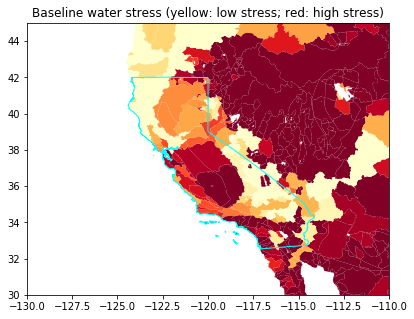

In [6]:
fig, ax = plt.subplots(figsize=[10,5])
ax.set_title('Baseline water stress (yellow: low stress; red: high stress)')
ax.set_ylim((30,45))
ax.set_xlim((-130,-110))
bws.plot(ax=ax, column='BWS_s', cmap='YlOrRd', vmin=0, vmax=5)
sample_data[sample_data.index==0].plot(ax=ax, color='', edgecolor='cyan')

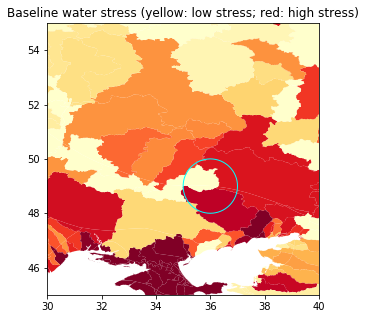

In [7]:
fig, ax = plt.subplots(figsize=[10,5])
ax.set_title('Baseline water stress (yellow: low stress; red: high stress)')
ax.set_ylim((45,55))
ax.set_xlim((30,40))
bws.plot(ax=ax, column='BWS_s', cmap='YlOrRd', vmin=0, vmax=5)
sample_data[sample_data.index==1].plot(ax=ax, color='', edgecolor='cyan')

# Crop producing regions

For each of our raw marial sources we want to focus only on the areas within the supply shed in which the crop is being grown.

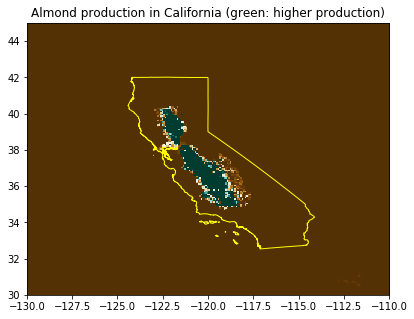

In [8]:
with rio.open('almond_HarvAreaYield_Geotiff/almond_Production.tif') as src:
    dat = src.read(1)
    fig, ax = plt.subplots(figsize=[10,5])
    ax.set_ylim((30,45))
    ax.set_xlim((-130,-110))
    rio.plot.show(dat, vmax=100, cmap='BrBG', ax=ax, transform=src.transform)
    sample_data[sample_data.index==0].plot(ax=ax, color='', edgecolor='yellow')
    ax.set_title('Almond production in California (green: higher production)')

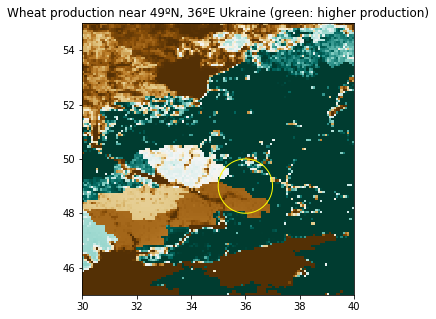

In [9]:
with rio.open('wheat_HarvAreaYield_Geotiff/wheat_Production.tif') as src:
    dat = src.read(1)
    fig, ax = plt.subplots(figsize=[10,5])
    ax.set_ylim((45,55))
    ax.set_xlim((30,40))
    rio.plot.show(dat, vmax=1000, cmap='BrBG', ax=ax, transform=src.transform)
    sample_data[sample_data.index==1].plot(ax=ax, color='', edgecolor='yellow')
    ax.set_title('Wheat production near 49ºN, 36ºE Ukraine (green: higher production)')

# Calculate weighted average of BWS

In [10]:
rastermapping = {
    'wheat flour':'wheat_HarvAreaYield_Geotiff/wheat_Production.tif',
    'almonds':'almond_HarvAreaYield_Geotiff/almond_Production.tif'
}

avg_bws = []

for idx, row in sample_data.iterrows():
    
    # clip the aqueduct basins to the geometry
    sample_data[sample_data.index==idx].to_file('geom')
    !mapshaper -i 'aqueduct_global_dl_20150409.shp' -clip 'geom/geom.shp' -o 'clipped.geojson'
    
    # calculate the sum of weights (crop production) for each basin
    zs = zonal_stats('clipped.geojson', rastermapping[row['raw material']], stats=['sum'], geojson_out=True, nodata=-999)
    aqueduct_stats = gpd.GeoDataFrame.from_features(zs)
    aqueduct_stats = aqueduct_stats[aqueduct_stats['BWS'].notna()]
    
    # calculate weighted average
    avg_bws.append((aqueduct_stats['BWS']*aqueduct_stats['sum']).sum() / aqueduct_stats['sum'].sum())

sample_data['avg_bws'] = avg_bws
sample_data.head()

[o] Wrote clipped.geojson
[o] Wrote clipped.geojson


,location,raw material,tonnage,year,geometry,avg_bws
0,California,almonds,15,2017,(POLYGON ((-117.2328491210937 32.7764053344726...,1.509370
1,"Flour mill @ 36N, 49E",wheat flour,2100,2017,"POLYGON ((37 49, 36.9951847266722 48.901982859...",0.506039


# Calculate gap to sustainable water withdrawals

In [11]:
# look up water footprint from table (here hardcoded)
water_withdrawals_ton = {
    'wheat flour': 299, # m3/ton
    'almonds': 7268
}
sample_data['withdrawal_ton'] = sample_data['raw material'].apply(lambda x:water_withdrawals_ton[x])

# calculate total withdrawals
sample_data['total_withdrawal'] = sample_data['tonnage'] * sample_data['withdrawal_ton']
sample_data.head()

,location,raw material,tonnage,year,geometry,avg_bws,withdrawal_ton,total_withdrawal
0,California,almonds,15,2017,(POLYGON ((-117.2328491210937 32.7764053344726...,1.509370,7268,109020
1,"Flour mill @ 36N, 49E",wheat flour,2100,2017,"POLYGON ((37 49, 36.9951847266722 48.901982859...",0.506039,299,627900


In [12]:
# Calculate how far we are in excess of the 0.4 threshold
excess_bws = (sample_data['avg_bws'] - 0.4) / sample_data['avg_bws']
excess_bws[excess_bws < 0] = 0

# Multiply total withdrawals by how much the location is in excess
sample_data['gap'] = excess_bws * sample_data['total_withdrawal']
sample_data.to_csv('output.csv')
sample_data.head()

,location,raw material,tonnage,year,geometry,avg_bws,withdrawal_ton,total_withdrawal,gap
0,California,almonds,15,2017,(POLYGON ((-117.2328491210937 32.7764053344726...,1.509370,7268,109020,80128.476638
1,"Flour mill @ 36N, 49E",wheat flour,2100,2017,"POLYGON ((37 49, 36.9951847266722 48.901982859...",0.506039,299,627900,131574.439385
